In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

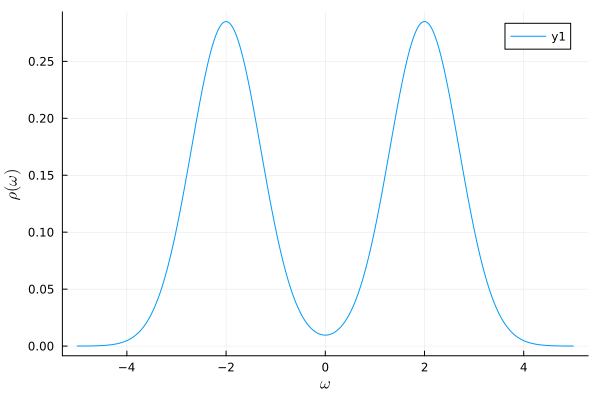

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = 0.5*gaussian(omega, -2.0, 0.7) + 0.5*gaussian(omega, 2.0, 0.7)
omegas = LinRange(-5, 5, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [7]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 31
H=1
Iter     Function value   Gradient norm 
     0     8.335648e+00     1.737675e+01
 * time: 0.014261960983276367
     1     6.844257e+00     3.230373e-01
 * time: 0.8632619380950928
     2     5.642148e+00     2.369929e-01
 * time: 1.0918729305267334
     3     4.910338e+00     1.775295e-01
 * time: 1.337249994277954
     4     4.436611e+00     7.293099e-02
 * time: 1.7581400871276855
     5     4.424518e+00     8.022835e-02
 * time: 1.888942003250122
     6     4.420029e+00     5.108143e-02
 * time: 2.0129430294036865
     7     4.410498e+00     8.199219e-02
 * time: 2.2289440631866455
     8     4.408400e+00     6.572905e-02
 * time: 2.6013050079345703
     9     4.404787e+00     7.677642e-02
 * time: 2.8897290229797363
    10     4.404594e+00     5.005465e-02
 * time: 3.3481059074401855
    11     4.404332e+00     1.658217e-01
 * time: 3.595278024673462
    12     4.403821e+00     6.007751e-02
 * time: 4.348798990249634
    13     4.402995e+00     9.644561e

   119     4.319416e+00     4.126128e-04
 * time: 55.0609290599823
   120     4.319416e+00     1.880357e-04
 * time: 55.18176198005676
   121     4.319416e+00     4.998885e-04
 * time: 55.27845096588135
   122     4.319416e+00     1.639879e-04
 * time: 55.39958906173706
   123     4.319416e+00     5.666342e-04
 * time: 55.59675693511963
   124     4.319416e+00     1.778743e-04
 * time: 55.68800497055054
   125     4.319415e+00     3.886303e-04
 * time: 55.92184805870056
   126     4.319415e+00     1.053134e-04
 * time: 56.04435706138611
   127     4.319415e+00     4.569695e-05
 * time: 56.209977865219116
   128     4.319415e+00     9.019596e-05
 * time: 56.38380289077759
   129     4.319415e+00     3.017820e-05
 * time: 56.50565695762634
   130     4.319415e+00     3.764491e-05
 * time: 56.67873191833496
   131     4.319415e+00     5.688149e-05
 * time: 56.79490804672241
   132     4.319415e+00     3.627226e-05
 * time: 56.91198801994324
   133     4.319415e+00     4.652573e-05
 * time

   240     4.319415e+00     8.400871e-07
 * time: 69.92088294029236
   241     4.319415e+00     1.727771e-06
 * time: 70.02385091781616
   242     4.319415e+00     7.996569e-07
 * time: 70.15419101715088
   243     4.319415e+00     1.597304e-06
 * time: 70.30131602287292
   244     4.319415e+00     7.677004e-07
 * time: 70.43843102455139
   245     4.319415e+00     1.464008e-06
 * time: 70.57524394989014
   246     4.319415e+00     7.338516e-07
 * time: 70.70057988166809
   247     4.319415e+00     1.359294e-06
 * time: 70.79759502410889
   248     4.319415e+00     6.917210e-07
 * time: 70.9166009426117
   249     4.319415e+00     1.257133e-06
 * time: 71.03828191757202
   250     4.319415e+00     6.386742e-07
 * time: 71.16540598869324
   251     4.319415e+00     1.142739e-06
 * time: 71.29781293869019
   252     4.319415e+00     5.770416e-07
 * time: 71.42957401275635
   253     4.319415e+00     1.030743e-06
 * time: 71.52717995643616
   254     4.319415e+00     5.292782e-07
 * time:

    25     4.123061e+00     1.324604e-02
 * time: 5.6657631397247314
    26     4.122894e+00     1.343190e-02
 * time: 5.800559997558594
    27     4.122505e+00     1.365796e-02
 * time: 5.9117960929870605
    28     4.121598e+00     1.660044e-02
 * time: 6.1793739795684814
    29     4.119364e+00     1.409664e-02
 * time: 6.4045491218566895
    30     4.117799e+00     2.005762e-02
 * time: 6.51485013961792
    31     4.113696e+00     1.371386e-02
 * time: 6.7317609786987305
    32     4.112789e+00     1.454816e-02
 * time: 6.866153001785278
    33     4.111798e+00     1.744871e-02
 * time: 7.00005316734314
    34     4.110143e+00     1.823088e-02
 * time: 7.211652994155884
    35     4.108989e+00     1.541185e-02
 * time: 7.420614957809448
    36     4.107789e+00     1.495583e-02
 * time: 7.62220311164856
    37     4.106936e+00     7.786079e-03
 * time: 7.760693073272705
    38     4.106254e+00     7.515365e-03
 * time: 7.958904027938843
    39     4.106001e+00     7.102384e-03
 * ti

In [8]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=3
Iter     Function value   Gradient norm 
     0     7.754097e-02     8.687431e-09
 * time: 0.00016689300537109375
max_theta=0.5451724562627658280071093536277695042847
hardy optimization was success.
H=4
Iter     Function value   Gradient norm 
     0     7.754097e-02     3.296762e-01
 * time: 0.00016188621520996094
     1     3.591535e-02     1.438118e-01
 * time: 0.15159893035888672
     2     2.052964e-02     3.485987e-02
 * time: 0.30679893493652344
     3     1.932424e-02     1.662538e-02
 * time: 0.4555940628051758
     4     1.907743e-02     6.977986e-03
 * time: 0.6062359809875488
     5     1.901132e-02     5.025713e-03
 * time: 0.8137619495391846
     6     1.891208e-02     4.273682e-03
 * time: 1.0511040687561035
     7     1.884758e-02     3.490796e-03
 * time: 1.2713119983673096
     8     1.881873e-02     1.088377e-03
 * time: 1.4287710189819336
     9     1.881677e-02     2.692114e-04
 * time: 1.5790798664093018
    10     1.881667e-02     9.141209e-05
 * time: 1.8174

    26     2.124317e-04     9.497288e-08
 * time: 7.249817132949829
    27     2.124317e-04     3.458086e-08
 * time: 7.460662126541138
    28     2.124317e-04     1.225813e-08
 * time: 7.661609172821045
    29     2.124317e-04     3.447998e-09
 * time: 7.970350980758667
max_theta=0.6378851030168626517825579215862626903303
hardy optimization was success.
H=9
Iter     Function value   Gradient norm 
     0     2.124317e-04     6.993067e-03
 * time: 0.00017595291137695312
     1     1.996766e-04     3.522024e-03
 * time: 0.21547389030456543
     2     1.899599e-04     2.203560e-03
 * time: 0.45111584663391113
     3     1.784862e-04     1.537507e-03
 * time: 0.7798337936401367
     4     1.737737e-04     1.108365e-03
 * time: 0.9953088760375977
     5     1.721497e-04     6.627296e-04
 * time: 1.2007229328155518
     6     1.696219e-04     7.374208e-04
 * time: 1.5162668228149414
     7     1.670386e-04     9.124219e-04
 * time: 1.8535828590393066
     8     1.636301e-04     9.125927e-04

    32     6.983449e-05     7.749169e-06
 * time: 11.976014852523804
    33     6.983427e-05     1.125058e-05
 * time: 12.338480949401855
    34     6.983379e-05     1.821132e-05
 * time: 12.702776908874512
    35     6.983288e-05     2.633228e-05
 * time: 13.063784837722778
    36     6.983091e-05     3.741481e-05
 * time: 13.44063687324524
    37     6.982720e-05     5.285037e-05
 * time: 13.814985036849976
    38     6.981909e-05     7.890619e-05
 * time: 14.205694913864136
    39     6.980369e-05     1.073222e-04
 * time: 14.573161840438843
    40     6.977004e-05     1.417179e-04
 * time: 14.94535493850708
    41     6.970714e-05     1.515649e-04
 * time: 15.31590986251831
    42     6.961012e-05     6.858409e-05
 * time: 15.723526000976562
    43     6.958838e-05     3.284985e-05
 * time: 16.162264823913574
    44     6.958586e-05     6.088205e-06
 * time: 16.40841293334961
    45     6.958572e-05     2.619856e-06
 * time: 16.843085050582886
    46     6.958570e-05     1.270437e-

    29     6.494100e-05     4.917420e-05
 * time: 11.690908908843994
    30     6.492849e-05     2.549924e-05
 * time: 12.094835042953491
    31     6.492706e-05     1.400589e-05
 * time: 12.356646060943604
    32     6.492555e-05     2.252061e-05
 * time: 12.784580945968628
    33     6.492339e-05     3.252330e-05
 * time: 13.18759799003601
    34     6.491874e-05     5.093146e-05
 * time: 13.586585998535156
    35     6.491124e-05     6.354858e-05
 * time: 13.987987995147705
    36     6.489753e-05     8.800099e-05
 * time: 14.42096495628357
    37     6.487489e-05     1.183421e-04
 * time: 14.831417083740234
    38     6.483343e-05     1.587710e-04
 * time: 15.233439922332764
    39     6.476157e-05     1.962560e-04
 * time: 15.62781286239624
    40     6.461953e-05     1.828913e-04
 * time: 16.03348207473755
    41     6.446201e-05     6.436519e-05
 * time: 16.46232008934021
    42     6.445225e-05     2.226957e-05
 * time: 16.71804904937744
    43     6.444973e-05     7.332524e-06

    66     6.394959e-05     1.250260e-06
 * time: 29.19991683959961
    67     6.394959e-05     1.628908e-06
 * time: 29.645381927490234
    68     6.394958e-05     2.000120e-06
 * time: 30.09028387069702
    69     6.394958e-05     2.577991e-06
 * time: 30.56201195716858
    70     6.394957e-05     3.148123e-06
 * time: 31.000293970108032
    71     6.394956e-05     4.037656e-06
 * time: 31.442827939987183
    72     6.394954e-05     4.917279e-06
 * time: 31.893041849136353
    73     6.394950e-05     6.285180e-06
 * time: 32.39140200614929
    74     6.394946e-05     7.641413e-06
 * time: 32.85010004043579
    75     6.394938e-05     9.742780e-06
 * time: 33.290748834609985
    76     6.394926e-05     1.183369e-05
 * time: 33.74128484725952
    77     6.394907e-05     1.504941e-05
 * time: 34.21084690093994
    78     6.394879e-05     1.824684e-05
 * time: 34.645283937454224
    79     6.394829e-05     2.302110e-05
 * time: 35.10088086128235
    80     6.394755e-05     2.762543e-05
 

    89     6.377560e-05     2.537945e-07
 * time: 37.66177701950073
    90     6.377560e-05     2.762660e-07
 * time: 38.01415205001831
    91     6.377560e-05     4.186801e-07
 * time: 38.552303075790405
    92     6.377560e-05     4.565287e-07
 * time: 38.94066095352173
    93     6.377560e-05     6.976882e-07
 * time: 39.50271391868591
    94     6.377560e-05     7.606815e-07
 * time: 39.857008934020996
    95     6.377560e-05     1.121009e-06
 * time: 40.455430030822754
    96     6.377560e-05     1.218587e-06
 * time: 40.82105612754822
    97     6.377559e-05     1.800750e-06
 * time: 41.36404013633728
    98     6.377559e-05     1.958916e-06
 * time: 41.66585111618042
    99     6.377558e-05     2.851892e-06
 * time: 42.142616987228394
   100     6.377558e-05     3.095807e-06
 * time: 42.49014115333557
   101     6.377555e-05     4.496171e-06
 * time: 42.94977593421936
   102     6.377554e-05     4.876786e-06
 * time: 43.28175902366638
   103     6.377548e-05     7.000358e-06
 * 

    84     6.373456e-05     7.684830e-06
 * time: 36.394192934036255
    85     6.373448e-05     9.585644e-06
 * time: 36.881876945495605
    86     6.373438e-05     1.116289e-05
 * time: 37.223731994628906
    87     6.373422e-05     1.376842e-05
 * time: 37.71157503128052
    88     6.373403e-05     1.597390e-05
 * time: 38.227641105651855
    89     6.373370e-05     1.953828e-05
 * time: 38.712443113327026
    90     6.373327e-05     2.258005e-05
 * time: 39.200252056121826
    91     6.373250e-05     2.715733e-05
 * time: 39.72997307777405
    92     6.373129e-05     3.053978e-05
 * time: 40.25728893280029
    93     6.372814e-05     2.954095e-05
 * time: 40.79243588447571
    94     6.372285e-05     1.468573e-05
 * time: 41.3171010017395
    95     6.372242e-05     3.610106e-06
 * time: 41.63013410568237
    96     6.372232e-05     1.660421e-06
 * time: 42.13962388038635
    97     6.372230e-05     1.255259e-06
 * time: 42.62672305107117
    98     6.372230e-05     2.958212e-07
 *

    96     6.371417e-05     6.342777e-07
 * time: 42.65886902809143
    97     6.371417e-05     7.256240e-07
 * time: 42.971845865249634
    98     6.371417e-05     8.412364e-07
 * time: 43.31637382507324
    99     6.371417e-05     9.582517e-07
 * time: 43.630223989486694
   100     6.371417e-05     1.105705e-06
 * time: 43.97641205787659
   101     6.371417e-05     1.255197e-06
 * time: 44.32574105262756
   102     6.371417e-05     1.443928e-06
 * time: 44.6448290348053
   103     6.371417e-05     1.634951e-06
 * time: 44.997763872146606
   104     6.371416e-05     1.877015e-06
 * time: 45.31486988067627
   105     6.371416e-05     2.121982e-06
 * time: 45.65694785118103
   106     6.371416e-05     2.433234e-06
 * time: 46.00411891937256
   107     6.371415e-05     2.748451e-06
 * time: 46.3206889629364
   108     6.371415e-05     3.150226e-06
 * time: 46.870043992996216
   109     6.371414e-05     3.557265e-06
 * time: 47.20143985748291
   110     6.371413e-05     4.078522e-06
 * ti

    80     6.370843e-05     7.947633e-06
 * time: 40.274405002593994
    81     6.370838e-05     8.102236e-06
 * time: 40.65903186798096
    82     6.370821e-05     1.045968e-05
 * time: 41.18632888793945
    83     6.370809e-05     1.083091e-05
 * time: 41.74777793884277
    84     6.370760e-05     1.249639e-05
 * time: 42.26858687400818
    85     6.370668e-05     8.627171e-06
 * time: 42.98208689689636
    86     6.370650e-05     4.116469e-06
 * time: 43.35738682746887
    87     6.370637e-05     2.310258e-06
 * time: 43.732932806015015
    88     6.370636e-05     1.386426e-06
 * time: 44.069087982177734
    89     6.370635e-05     1.042976e-06
 * time: 44.63979697227478
    90     6.370634e-05     3.406462e-07
 * time: 44.97696590423584
    91     6.370634e-05     3.064902e-07
 * time: 45.54976797103882
    92     6.370634e-05     1.612141e-07
 * time: 45.886884927749634
    93     6.370634e-05     1.126420e-07
 * time: 46.45833492279053
    94     6.370634e-05     4.181791e-08
 * 

   201     6.370231e-05     2.024473e-05
 * time: 89.78544878959656
   202     6.370208e-05     2.263280e-05
 * time: 90.3281638622284
   203     6.370180e-05     2.477074e-05
 * time: 90.65254092216492
   204     6.370143e-05     2.776060e-05
 * time: 91.19304490089417
   205     6.370097e-05     3.043014e-05
 * time: 91.55444478988647
   206     6.370034e-05     3.420735e-05
 * time: 92.06005597114563
   207     6.369953e-05     3.756125e-05
 * time: 92.57542991638184
   208     6.369828e-05     4.230890e-05
 * time: 93.12138795852661
   209     6.369645e-05     4.630789e-05
 * time: 93.62509679794312
   210     6.369249e-05     5.028054e-05
 * time: 94.17468595504761
   211     6.367988e-05     3.993115e-05
 * time: 94.85501790046692
   212     6.367241e-05     3.359348e-05
 * time: 95.36817693710327
   213     6.366893e-05     1.473009e-05
 * time: 95.72106385231018
   214     6.366786e-05     1.026553e-05
 * time: 96.08820390701294
   215     6.366760e-05     5.123036e-06
 * time:

    89     6.363530e-05     7.490840e-07
 * time: 44.38631010055542
    90     6.363530e-05     6.736608e-07
 * time: 44.91388297080994
    91     6.363530e-05     2.285431e-07
 * time: 45.29919695854187
    92     6.363530e-05     2.570845e-07
 * time: 45.821836948394775
    93     6.363530e-05     1.022659e-07
 * time: 46.20330309867859
    94     6.363530e-05     2.347429e-07
 * time: 46.73207211494446
    95     6.363529e-05     1.725240e-07
 * time: 47.11138200759888
    96     6.363529e-05     3.373114e-07
 * time: 47.67612099647522
    97     6.363529e-05     2.897821e-07
 * time: 48.014086961746216
    98     6.363529e-05     5.760607e-07
 * time: 48.578068017959595
    99     6.363529e-05     5.411981e-07
 * time: 48.91220998764038
   100     6.363529e-05     8.019212e-07
 * time: 49.482085943222046
   101     6.363529e-05     7.515338e-07
 * time: 49.828789949417114
   102     6.363529e-05     1.327886e-06
 * time: 50.406015157699585
   103     6.363529e-05     1.297415e-06
 

   210     6.357645e-05     7.661072e-08
 * time: 100.7428719997406
   211     6.357645e-05     3.783585e-08
 * time: 101.15343403816223
   212     6.357645e-05     3.779416e-08
 * time: 101.69239115715027
   213     6.357645e-05     1.576684e-08
 * time: 102.08952116966248
   214     6.357645e-05     1.562416e-08
 * time: 102.62394499778748
   215     6.357645e-05     7.198540e-09
 * time: 103.00773501396179
max_theta=0.7467393064689608126025521734218724154235
hardy optimization was success.
H=20
Iter     Function value   Gradient norm 
     0     6.357645e-05     1.114185e-04
 * time: 0.0001652240753173828
     1     6.357528e-05     6.685615e-05
 * time: 0.35940003395080566
     2     6.357428e-05     4.068406e-05
 * time: 0.7634031772613525
     3     6.357270e-05     3.870860e-05
 * time: 1.1569621562957764
     4     6.357008e-05     6.502557e-05
 * time: 1.5130960941314697
     5     6.356783e-05     5.141707e-05
 * time: 1.9236671924591064
     6     6.356412e-05     4.162014e-

   112     6.334848e-05     2.685509e-07
 * time: 57.43498706817627
   113     6.334848e-05     4.346080e-07
 * time: 57.83668398857117
   114     6.334848e-05     4.150263e-07
 * time: 58.18595314025879
   115     6.334848e-05     5.975128e-07
 * time: 58.57284998893738
   116     6.334848e-05     5.977374e-07
 * time: 58.97392916679382
   117     6.334848e-05     7.909793e-07
 * time: 59.3231360912323
   118     6.334848e-05     8.155048e-07
 * time: 59.71373701095581
   119     6.334847e-05     1.041654e-06
 * time: 60.115647077560425
   120     6.334847e-05     1.090254e-06
 * time: 60.46543002128601
   121     6.334847e-05     1.342669e-06
 * time: 60.85460901260376
   122     6.334847e-05     1.404553e-06
 * time: 61.25910019874573
   123     6.334847e-05     1.691466e-06
 * time: 61.61711001396179
   124     6.334846e-05     1.766164e-06
 * time: 62.00668716430664
   125     6.334846e-05     2.088305e-06
 * time: 62.40269207954407
   126     6.334846e-05     2.182353e-06
 * time

   233     6.329506e-05     7.917872e-06
 * time: 111.65596199035645
   234     6.329504e-05     8.135019e-06
 * time: 112.05645799636841
   235     6.329500e-05     9.142432e-06
 * time: 112.62010908126831
   236     6.329497e-05     9.391808e-06
 * time: 113.0307559967041
   237     6.329493e-05     1.054274e-05
 * time: 113.59312510490417
   238     6.329489e-05     1.082854e-05
 * time: 113.99900913238525
   239     6.329483e-05     1.214263e-05
 * time: 114.56518816947937
   240     6.329478e-05     1.246958e-05
 * time: 114.9695041179657
   241     6.329470e-05     1.396896e-05
 * time: 115.65135908126831
   242     6.329463e-05     1.434230e-05
 * time: 116.05782318115234
   243     6.329453e-05     1.605179e-05
 * time: 116.73604106903076
   244     6.329443e-05     1.647725e-05
 * time: 117.10421514511108
   245     6.329430e-05     1.842451e-05
 * time: 117.77826404571533
   246     6.329418e-05     1.890826e-05
 * time: 118.24144506454468
   247     6.329401e-05     2.112388

   353     6.312194e-05     7.446866e-05
 * time: 173.0190131664276
   354     6.311938e-05     7.421598e-05
 * time: 173.41079711914062
   355     6.311179e-05     7.888642e-05
 * time: 174.01038312911987
   356     6.310766e-05     7.925826e-05
 * time: 174.367121219635
   357     6.309529e-05     1.231595e-04
 * time: 174.9713261127472
   358     6.308875e-05     1.209141e-04
 * time: 175.32144403457642
   359     6.307811e-05     1.007008e-04
 * time: 175.9378581047058
   360     6.306973e-05     9.564448e-05
 * time: 176.33328199386597
   361     6.305226e-05     9.595608e-05
 * time: 177.08911418914795
   362     6.304393e-05     9.551526e-05
 * time: 178.03987908363342
   363     6.303701e-05     9.369388e-05
 * time: 178.63933420181274
   364     6.302198e-05     8.704638e-05
 * time: 178.99018216133118
   365     6.300168e-05     7.296459e-05
 * time: 179.59402418136597
   366     6.296814e-05     3.577808e-05
 * time: 179.9561550617218
   367     6.296108e-05     4.791678e-05

In [9]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31


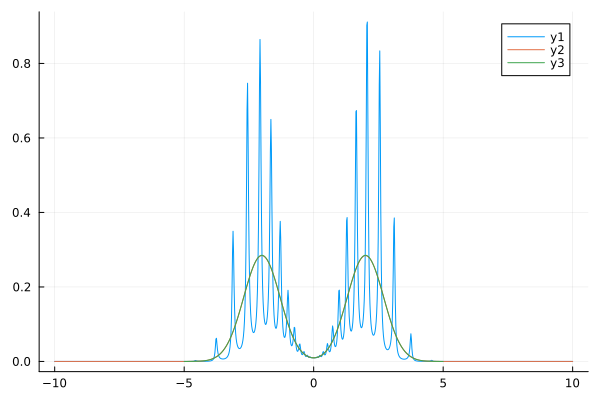

In [10]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [11]:
#=
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
#savefig("two_peak.svg")
=#

In [12]:
open("data/hubbard_wo_opt.dat","w") do f
    for i in 1:wo_sol.reals.N_real
        println(f, "$(Float64(real.(wo_sol.reals.freq[i])))",  "\t", "$(Float64(imag.(wo_sol.reals.val[i]/pi)))")
    end
end
open("data/hubbard_w_opt.dat","w") do g
    for i in 1:sol.reals.N_real
        println(g, "$(Float64(real.(sol.reals.freq[i])))",  "\t", "$(Float64(imag.(sol.reals.val[i]/pi)))")
    end
end
open("data/hubbard_exact.dat","w") do h
    for i in 1:length(omegas)
        println(h, omegas[i],  "\t", rho(omegas[i]))
    end
end